In [222]:
import pandas as pd
import numpy as np
import pyagrum as gum
import pyagrum.lib.notebook as gnb

# Show all columns
pd.set_option('display.max_columns', None)

# variable information 
vars_df = pd.read_csv('Dataset/processed_credit.csv')
vars_df

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,Critical account / other credits elsewhere,radio/television,Low,unknown / no savings,ge7 years,4,male: single,none,4,real estate,Old,none,own,2,skilled employee/official,1,yes (registered),yes,Good
1,0to200,Medium,Existing credits paid duly till now,radio/television,Low,lt100 DM,1to4 years,2,female: divorced/separated/married,none,2,real estate,Young,none,own,1,skilled employee/official,1,none,yes,Bad
2,No Checking,Short,Critical account / other credits elsewhere,education,Low,lt100 DM,4to7 years,2,male: single,none,3,real estate,Middle,none,own,1,unskilled - resident,2,none,yes,Good
3,lt0,Medium,Existing credits paid duly till now,furniture/equipment,Medium,lt100 DM,4to7 years,2,male: single,guarantor,4,building society savings / life insurance,Middle,none,for free,1,skilled employee/official,2,none,yes,Good
4,lt0,Short,Delay in paying off in the past,car (new),Low,lt100 DM,1to4 years,3,male: single,none,4,unknown / no property,Middle,none,for free,2,skilled employee/official,2,none,yes,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,No Checking,Short,Existing credits paid duly till now,furniture/equipment,Low,lt100 DM,4to7 years,3,female: divorced/separated/married,none,4,real estate,Young,none,own,1,unskilled - resident,1,none,yes,Good
996,lt0,Medium,Existing credits paid duly till now,car (used),Low,lt100 DM,1to4 years,4,male: divorced/separated,none,4,building society savings / life insurance,Middle,none,own,1,management/self-employed/highly qualified/officer,1,yes (registered),yes,Good
997,No Checking,Short,Existing credits paid duly till now,radio/television,Low,lt100 DM,ge7 years,4,male: single,none,4,car or other,Middle,none,own,1,skilled employee/official,1,none,yes,Good
998,lt0,Medium,Existing credits paid duly till now,radio/television,Low,lt100 DM,1to4 years,4,male: single,none,4,unknown / no property,Young,none,for free,1,skilled employee/official,1,yes (registered),yes,Bad


# Open a saved Bayesian network

In [223]:
import pyagrum.lib.notebook as gnb
import pyagrum as gum

filepath = 'BNs/GermanCreditManual.bif'
bn = gum.loadBN(filepath)
bn

(pyagrum.BayesNet@0000023385AC5D80) BN{nodes: 26, arcs: 36, domainSize: 10^13.7638, dim: 3736, mem: 55Ko 912o}

Populate random variable values with dataframe column value ranges

In [224]:
# Find observed and unobserved variables
bn_vars = set(bn.names())
df_vars = set(vars_df.columns)
observed_vars = df_vars.intersection(bn_vars)
unobserved_vars = bn_vars - observed_vars
print(f"Observed: {observed_vars}, Unobserved: {unobserved_vars}")
print(len(bn_vars))

Observed: {'EmploymentSince', 'OtherInstallmentPlans', 'InstallmentRate', 'CreditRisk', 'SavingsAccount', 'Property', 'CreditHistory', 'OtherDebtors', 'ForeignWorker', 'Purpose', 'Duration', 'Job', 'ResidenceSince', 'CreditAmount', 'Age', 'LiablePeople', 'CheckingAccount', 'PersonalStatusSex', 'ExistingCredits', 'Housing'}, Unobserved: {'Terms', 'Capital', 'Capacity', 'Character', 'Income', 'Collateral'}
26


In [225]:
def inspect_var_ranges(bn, df=None, sample_rows=5):
	"""Print labels for each variable in the influence diagram and sample uniques from df."""
    # print("Influence diagram variables and labels:")
	mismatches = []
	for var in bn.names():
		try:
			variable = bn.variable(var)
			try:
				labels = list(variable.labels())
			except Exception:
                # fall back to older API
				labels = [str(variable.label(i)) for i in range(variable.domainSize())]
			uniques = df[var].dropna().unique()
			
			if set(labels) != set(uniques):
				# print(f" - {var}: sample_uniques={list(sorted(map(str, uniques)))}")
				# print(f" - {var}: labels={labels}\n")
				print(f"Mismatch in variable '{var}':")
				print(set(labels), '\n', set(uniques))
				mismatches.append(var)
		except Exception as e:
			pass

	if mismatches:
		return set(mismatches)
	else:
		print("All variable labels match the dataset.")
		return None
    
mismatches = inspect_var_ranges(bn, df=vars_df)
mismatches

Mismatch in variable 'EmploymentSince':
{'_1to4_years', 'unemployed', '_4to7_years', 'ge7_years', 'lt1_year'} 
 {'lt1 year', 'unemployed', 'ge7 years', '4to7 years', '1to4 years'}
Mismatch in variable 'InstallmentRate':
{'4', '3', '2', '1'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Mismatch in variable 'SavingsAccount':
{'_500to1000_DM', '_100to500_DM', 'lt100_DM', 'ge1000_DM', 'unknown__no_savings'} 
 {'unknown / no savings', '500to1000 DM', '100to500 DM', 'lt100 DM', 'ge1000 DM'}
Mismatch in variable 'Property':
{'real_estate', 'building_society_savings__life_insurance', 'unknown__no_property', 'car_or_other'} 
 {'real estate', 'unknown / no property', 'building society savings / life insurance', 'car or other'}
Mismatch in variable 'OtherDebtors':
{'none', 'guarantor', 'co_applicant'} 
 {'none', 'guarantor', 'co-applicant'}
Mismatch in variable 'CreditHistory':
{'All_credits_at_this_bank_paid_duly', 'Delay_in_paying_off_in_the_past', 'Critical_account__other_credits_els

{'CheckingAccount',
 'CreditHistory',
 'EmploymentSince',
 'ExistingCredits',
 'Housing',
 'InstallmentRate',
 'Job',
 'LiablePeople',
 'OtherDebtors',
 'PersonalStatusSex',
 'Property',
 'Purpose',
 'ResidenceSince',
 'SavingsAccount'}

In [226]:
# Create mapping from dataset values to BN labels
value_to_label = {
    (var, val): label
    for var in mismatches
    for val, label in zip(sorted(vars_df[var].unique()), sorted(bn.variable(var).labels()))
}

# Map dataset values to BN labels in vars_df
for var in mismatches:
    # Convert column to string/object type to avoid dtype issues
    vars_df[var] = vars_df[var].astype(str)

for (var, val), label in value_to_label.items():
    vars_df.loc[vars_df[var] == str(val), var] = str(label)

# Verify that all mismatches have been resolved
mismatches_after = inspect_var_ranges(bn, df=vars_df)
mismatches_after
vars_df.head()

All variable labels match the dataset.


,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,Critical_account__other_credits_elsewhere,radio_television,Low,unknown__no_savings,ge7_years,4,male_single,none,4,real_estate,Old,none,own,2,skilled_employee_official,1,yes (registered),yes,Good
1,No_Checking,Medium,Existing_credits_paid_duly_till_now,radio_television,Low,lt100_DM,_1to4_years,2,female_divorced_separated_married,none,2,real_estate,Young,none,own,1,skilled_employee_official,1,none,yes,Bad
2,_0to200,Short,Critical_account__other_credits_elsewhere,education,Low,lt100_DM,_4to7_years,2,male_single,none,3,real_estate,Middle,none,own,1,unskilled__resident,2,none,yes,Good
3,lt0,Medium,Existing_credits_paid_duly_till_now,furniture_equipment,Medium,lt100_DM,_4to7_years,2,male_single,guarantor,4,building_society_savings__life_insurance,Middle,none,for_free,1,skilled_employee_official,2,none,yes,Good
4,lt0,Short,Delay_in_paying_off_in_the_past,car_new,Low,lt100_DM,_1to4_years,3,male_single,none,4,unknown__no_property,Middle,none,for_free,2,skilled_employee_official,2,none,yes,Bad


# Building probability tables

In [227]:
# Augment vars_df with unobserved variables (random values from BN labels)
unobs_seed = 42
np.random.seed(unobs_seed)

# Custom probabilities for unobserved variables
custom_probs = {
    "Collateral": [0.7, 0.2, 0.1],  
    "Capital": [0.7, 0.2, 0.1],
	"Capacity": [0.3, 0.4, 0.3],
	"Terms": [0.45, 0.35, 0.2],
	"Character": [0.22, 0.78],
	"Income": [0.1, 0.3, 0.6]
}

for var in unobserved_vars:
    labels = list(bn.variable(var).labels())
    probs = custom_probs.get(var, None)
    if probs is not None and len(probs) == len(labels):
        # Note use of np.random.choice with specified probabilities
        vars_df[var] = np.random.choice(labels, size=len(vars_df), p=probs)
    else:
        print(f"Warning: Using uniform distribution for '{var}' due to missing or mismatched custom probabilities.")
        # Fall back to uniform if no custom probs provided or length mismatch
        vars_df[var] = np.random.choice(labels, size=len(vars_df))
    print(f"Added column '{var}' with random values from {labels}")

# Only use vars from bn - telephone not in bn
vars_df = vars_df[list(bn.names())]

print(f"\nAugmented DataFrame shape: {vars_df.shape}")
vars_df.head()

Added column 'Terms' with random values from ['short', 'medium', 'long']
Added column 'Capital' with random values from ['low', 'medium', 'high']
Added column 'Capacity' with random values from ['low', 'medium', 'high']
Added column 'Character' with random values from ['bad', 'good']
Added column 'Income' with random values from ['low', 'medium', 'high']
Added column 'Collateral' with random values from ['none', 'some', 'good']

Augmented DataFrame shape: (1000, 26)


,EmploymentSince,OtherInstallmentPlans,InstallmentRate,CreditRisk,SavingsAccount,Property,OtherDebtors,ForeignWorker,Character,CreditHistory,Collateral,Purpose,Capacity,Duration,Income,Job,Terms,Capital,ResidenceSince,CreditAmount,Age,LiablePeople,CheckingAccount,PersonalStatusSex,ExistingCredits,Housing
0,ge7_years,none,4,Good,unknown__no_savings,real_estate,none,yes,good,Critical_account__other_credits_elsewhere,none,radio_television,low,Short,high,skilled_employee_official,short,low,4,Low,Old,1,lt0,male_single,2,own
1,_1to4_years,none,2,Bad,lt100_DM,real_estate,none,yes,good,Existing_credits_paid_duly_till_now,none,radio_television,low,Medium,high,skilled_employee_official,long,low,2,Low,Young,1,No_Checking,female_divorced_separated_married,1,own
2,_4to7_years,none,2,Good,lt100_DM,real_estate,none,yes,good,Critical_account__other_credits_elsewhere,some,education,high,Short,high,unskilled__resident,medium,medium,3,Low,Middle,2,_0to200,male_single,1,own
3,_4to7_years,none,2,Good,lt100_DM,building_society_savings__life_insurance,guarantor,yes,good,Existing_credits_paid_duly_till_now,none,furniture_equipment,low,Medium,medium,skilled_employee_official,medium,medium,4,Medium,Middle,2,lt0,male_single,1,for_free
4,_1to4_years,none,3,Bad,lt100_DM,unknown__no_property,none,yes,good,Delay_in_paying_off_in_the_past,some,car_new,low,Short,medium,skilled_employee_official,short,medium,4,Low,Middle,2,lt0,male_single,2,for_free


In [228]:
queries = {"OtherDebtors", "EmploymentSince", "PersonalStatusSex", "LiablePeople", "CheckingAccount", "SavingsAccount"}

def populate_cpts(bn, df, alpha=1.0):
    df = df.copy()

    for var in bn.names():
        # ensure label types are strings and in BN order
        labels = [str(l) for l in bn.variable(var).labels()]
        parents = [bn.variable(pid).name() for pid in bn.parents(bn.idFromName(var))]

        if not parents:
            counts = df[var].astype(str).value_counts().reindex(labels, fill_value=0)
            smoothed = counts + alpha
            probs = (smoothed / smoothed.sum()).astype(float).values
            bn.cpt(var).fillWith(probs)
        else:
            # Ordered list of parent label lists (keeps order consistent with `parents`)
            parent_labels_list = [[str(l) for l in bn.variable(p).labels()] for p in parents]

            # Build index appropriate to number of parents
            if len(parents) == 1:
                index = pd.Index(parent_labels_list[0], name=parents[0])
            else:
                index = pd.MultiIndex.from_product(parent_labels_list, names=parents)

            # Group using stringified values so they match BN labels exactly
            grp = df[parents + [var]].astype(str)
            counts = grp.groupby(parents)[var].value_counts().unstack(fill_value=0)

            # reindex -> guarantees all parent combinations and child labels present (zeros where missing)
            counts = counts.reindex(index=index, columns=labels, fill_value=0)

            # Laplace smoothing and row-normalise
            smoothed = counts + alpha
            cond = smoothed.div(smoothed.sum(axis=1), axis=0).fillna(0)

            # set CPT entries
            for idx, row in cond.iterrows():
                if len(parents) == 1:
                    parent_assignment = {parents[0]: idx}
                else:
                    parent_assignment = dict(zip(parents, idx if isinstance(idx, tuple) else (idx,)))
                pr = row.astype(float).values.tolist()
                bn.cpt(var)[parent_assignment] = pr

    return bn

bn = populate_cpts(bn, vars_df, alpha=1.0)

# Inference using the Bayesian Network

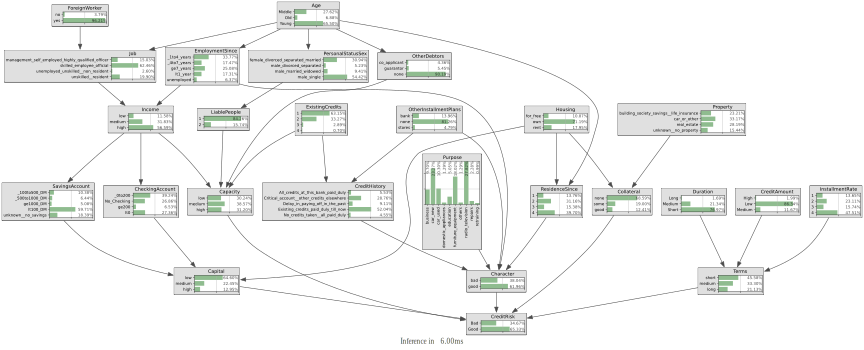

In [229]:
gum.config.reset()
# Inference
gnb.showInference(bn, size="12")

Given 5 C's lets test it's impact on the perceived Credit Risk

{'Terms', 'Character', 'Capital', 'Capacity', 'Income', 'Collateral', 'CreditRisk'}


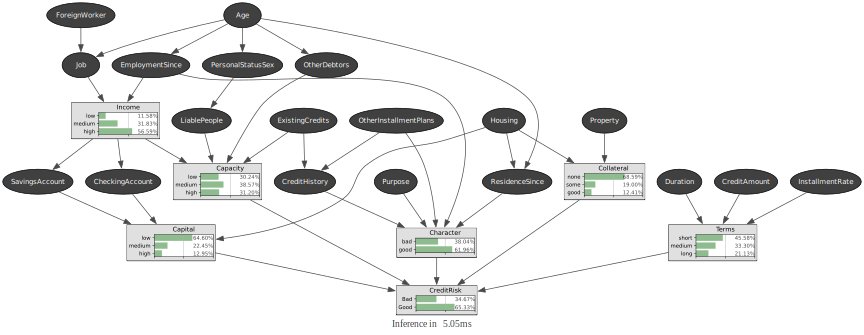

In [242]:
targets = unobserved_vars.union({"CreditRisk"})
print(targets)
gnb.showInference(bn,evs={},targets=targets, size="12")
# gnb.showInference(bn,evs={"CreditRisk": "Good"},targets=targets, size="12")
# gnb.showInference(bn,evs={"CreditRisk": "Bad"},targets=targets, size="12")
# gnb.showInference(bn,evs={"Character": "bad"},targets=targets, size="12")

# Causal reasoning

We explore the effect that parent nodes have on the perceived credit risk of applicants, investigating the link between employment, asset ownership and the financial wellbeing of applicants. 

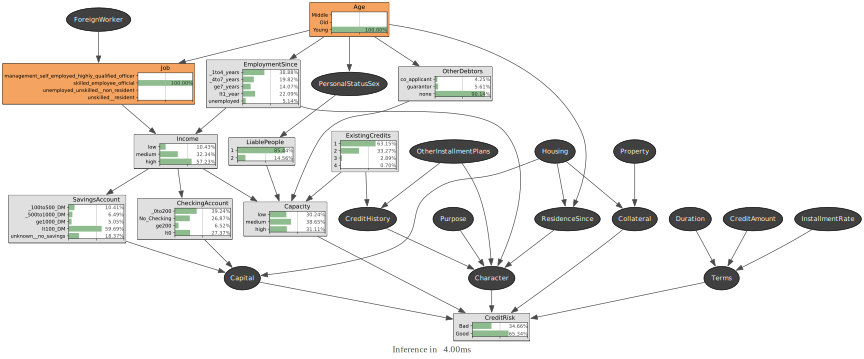

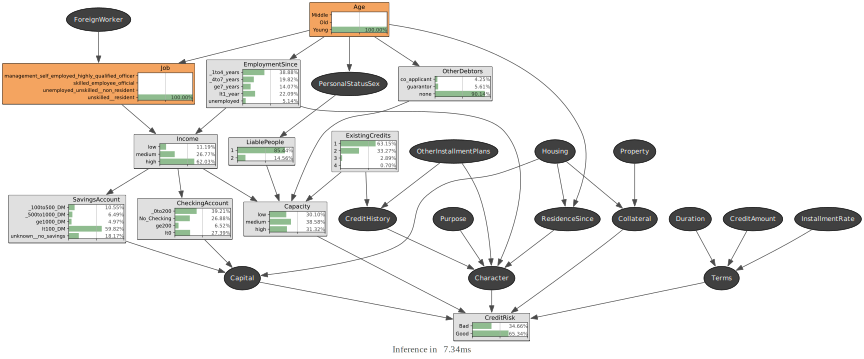

In [253]:
employment = {"CreditRisk", "Job", "Age", "EmploymentSince", "Income", "Capacity",
              "LiablePeople", "ExistingCredits", "OtherDebtors", "CheckingAccount", "SavingsAccount"}

gnb.showInference(bn,evs={"Age": "Young", "Job": "skilled_employee_official"},targets=employment, size="12")
gnb.showInference(bn,evs={"Age": "Young", "Job": "unskilled__resident"},targets=employment, size="12")
# gnb.showInference(bn,evs={"CreditRisk": "Bad"},targets=employment, size="12")
# gnb.showInference(bn,evs={"Character": "bad"},targets=employment, size="12")

In [231]:
# Save the bn
bn.saveBIF('BNs/GermanCreditManual_filled.bif')

# Creating Influence diagram


Ensuring that 5 C's are used in deciding whether to approve or deny loan

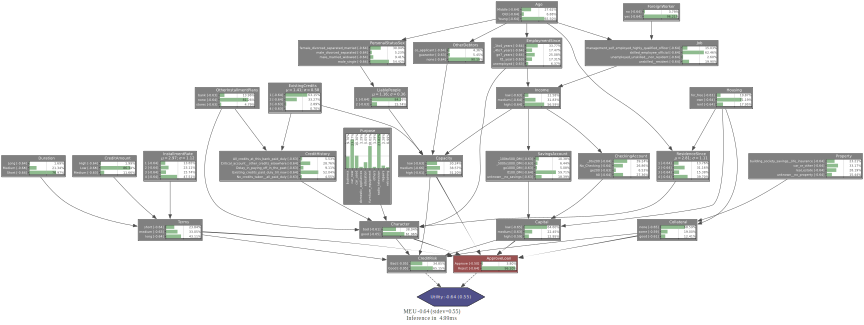

In [232]:
# Load the influence diagram
influence_diagram = gum.loadID('IDs/credit_decision_influence_diagram.xml')

# Add the parents of credit risk to the action node

parents = bn.parents("CreditRisk")
decision_name = "ApproveLoan"

for parent in parents:
    parent_name = bn.variable(parent).name()
    influence_diagram.addArc(parent_name, decision_name)

gnb.showInference(influence_diagram, size="12")

# Structure and weights

1) The structure was decided upon based on the 5 C's of Credit framework. All parent nodes are used to influence the perceived Credit Risk of a given applicant. Majority discussed in previous sections.

# Parameters and weights

2) The set of variables contained in the dataset allowed us to build probability tables based on the occurence of values in the data. The dataset grounds some of the beliefs we have about applicants. 

Firstly, the variables not present in the dataset were assigned the following probability distribution:

"Collateral": {'none': 0.7, 'some': 0.2, 'good': 0.1},  
"Capital": {'low': 0.7, 'medium': 0.2, 'high': 0.1},
"Capacity": {'low': 0.3, 'medium': 0.4, 'high': 0.3},
"Terms": {'short': 0.45, 'medium': 0.35, 'long': 0.2},
"Character": {'bad': 0.22, 'good': 0.78},
"Income": {'low': 0.1, 'medium': 0.3, 'high': 0.6}

Collateral: Majority of applicants for this type of loan are not securing it with significant assets. Most (70%) offer no collateral, which is typical for personal or consumer loans. A small fraction have some or good collateral, representing a lower-risk minority. Often, one would need to own a large asset to use it as collateral and the assumption is that few individuals would use their homes as collateral for a large credit amount due to the riskiness of the decision.
However, given that majority of sampled applicants in the dataset had a car or owned a house, the probability that an applicant had some collateral should not be too low.

Capital: The assumption is that fewer applicants were high net worth individuals with available capital to use for the loan. Based on the data most applicants applied for smaller credit amounts and more often than not small loans would not be made by individuals with large capital resources.

Terms: Given the preference for short-term loans. The highest probability (45%) is assigned to "short" terms, which implies that loans are for smaller amounts that can be paid back quickly, or that the lender prefers to minimize long-term risk exposure.

Character: This encodes a strong prior and optimism that most applicants have paid previous credit and discipline.

Income: Suggests the model is focused on a population where "high" income is the most common characteristic (60%). This could mean the loan product targets more affluent customers, or that a "high" income is a soft prerequisite for consideration, thus filtering out most low-income individuals. This ties in with the optimistic assumption of positive borrowers who have good credit history. As a bank one would advertise credit products to high income individuals who have a good credit history.

After adding synthetic data for these variables in the data frame according to these prior marginals, we populate the tables using the joint distributions derived from the co-occurence of values that the random variables take on in the dataset.

# Inference using the influence diagram


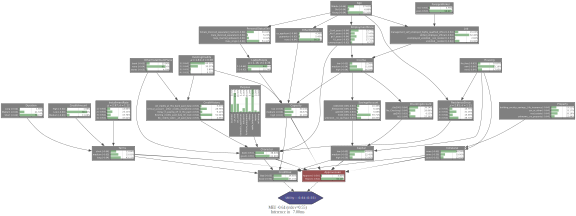

In [233]:
# Diagnostic Inference
gnb.showInference(influence_diagram)
